In [87]:
import mrc #All functionality for the MRC is included in this library
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sg 
import time

mrr = mrc.Console(frequency=22.05e6)              # Connect to the MRR and initialize the system

AutoDetectException: Port AutoDetect Failed. Is the MRC Connected Properly?

In [5]:
sos = sg.butter(20, 10e3, 'low', fs=100e3, output='sos')

## Figure 2

Setting Coil Strength to 9.3 Counts/Hz
Setting Frequency to 22053000.0
Loading Sequence... Done.
Running Sequence
Received Bytes: 241344



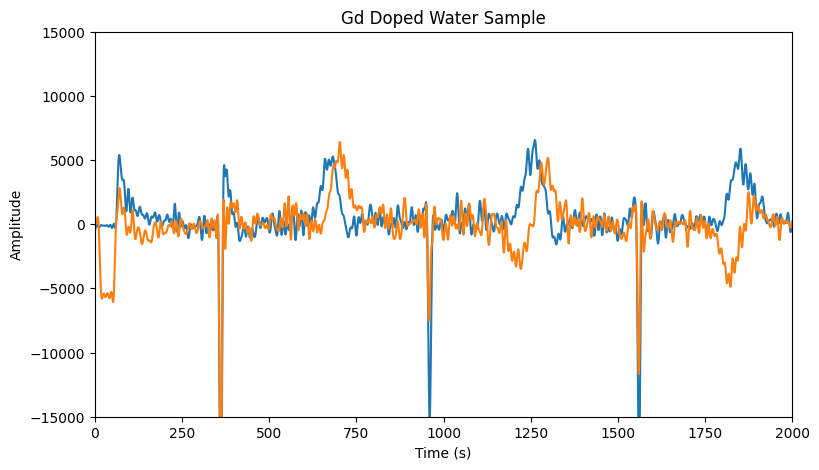

In [6]:
mrr.amp(9.3)
mrr.freq(22.053e6)
mrr.run(mrc.build_cpmg(6e-3, 100, 500e-6, 150e-6))
rx_data1 = sg.sosfiltfilt(sos, mrr.rx_data * np.exp(-1j*(np.angle(mrr.rx_data[19]) + np.pi/2)))
# rx_data1 = mrr.rx_data * np.exp(-1j*(np.angle(mrr.rx_data[19]) + np.pi/2))

cpmg_fig = plt.figure(figsize=(9,5))                                      # Plot the results
plt.plot(np.real(rx_data1))
plt.plot(np.imag(rx_data1))
plt.ylim([-15000,15000])
plt.xlim([0,2000])
plt.title("Gd Doped Water Sample")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
# plt.legend(["$T_2$ = %0.2f" % (mrc.get_t2(echo_amplitudes, 3e-3))]) # Put the calculated T2 in the legend
plt.show()  

Setting Coil Strength to 9.3 Counts/Hz
Loading Sequence... Done.
Running Sequence
Received Bytes: 320448



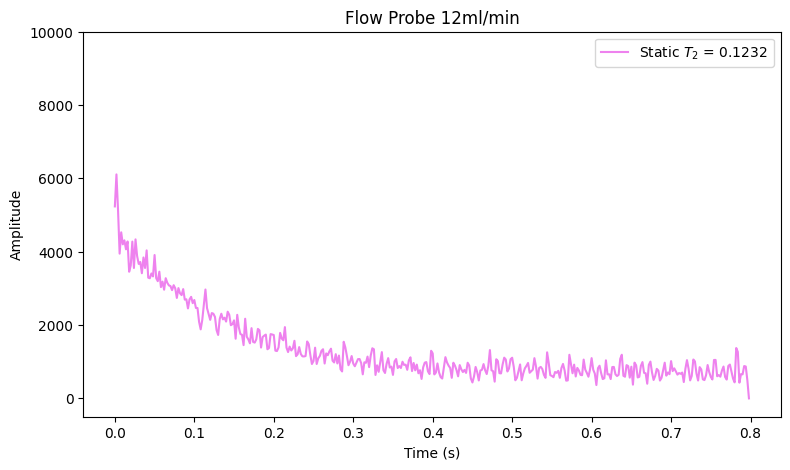

In [80]:
mrr.amp(9.3)
t_echo = 2e-3
num_echoes = 400
onlystatic = True
t90 = 300e-6
t180 = 300e-6

mrr.run_cpmg(num_echoes, t_echo, t90, t180)
echo_times = np.arange(0, t_echo * num_echoes, t_echo)
mrr.rx_data = mrr.rx_data * np.exp(-1j*(np.angle(mrr.rx_data[19]) + np.pi/2))
filtdata = sg.sosfiltfilt(sos, mrr.rx_data)
static_echo_amplitudes = mrc.get_echo_amplitudes(filtdata, num_echoes, t_echo, t90, use_real=False)
# mrr.run(mrc.build_spinecho(3e-3, 300e-6, 300e-6))
if not onlystatic:
    time.sleep(15)
    echo_times, forward_echo_amplitudes = mrr.run_cpmg(num_echoes, t_echo, t90, t180)
    mrr.run(mrc.build_spinecho(3e-3, 300e-6, 300e-6))
    time.sleep(15)
    echo_times, reverse_echo_amplitudes = mrr.run_cpmg(num_echoes, t_echo, t90, t180)
    # mrr.run(mrc.build_spinecho(3e-3, 300e-6, 300e-6))

cpmg_fig = plt.figure(figsize=(9,5))                                      # Plot the results
# plt.plot(echo_times, echo_amplitudes, color='violet')
plt.plot(echo_times, static_echo_amplitudes, color='violet')
if not onlystatic:
    plt.plot(echo_times, forward_echo_amplitudes, color='purple')
    plt.plot(echo_times, reverse_echo_amplitudes, color='blueviolet')
plt.title("Flow Probe 12ml/min")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
if(onlystatic):
    plt.legend(["Static $T_2$ = %0.4f" % (mrc.get_t2(static_echo_amplitudes, t_echo))])
else:
    plt.legend(["Static $T_2$ = %0.2f" % (mrc.get_t2(static_echo_amplitudes, t_echo)),
                "Forward $T_2$ = %0.2f" % (mrc.get_t2(forward_echo_amplitudes, t_echo)),
                "Reverse $T_2$ = %0.2f" % (mrc.get_t2(reverse_echo_amplitudes, t_echo))]) # Put the calculated T2 in the legend
plt.ylim([-500, 10000])
plt.show()     

In [185]:
np.save("05_ccw_2.npy", mrr.rx_data, allow_pickle=True)

# Process Monitoring

In [59]:
from pump import *
peri = Pump()
time.sleep(1)
import datetime
peri.setspeed(2, 30)
time.sleep(2)
peri.setdir(2, 'ccw')


In [81]:
ft2s = np.empty(0)
bt2s = np.empty(0)

numeach = 20
for i in range(4*numeach):
    time.sleep(10)

    # take a flow measurement
    mrr.run_cpmg(num_echoes, t_echo, t90, t180)
    echo_times = np.arange(0, t_echo * num_echoes, t_echo)
    mrr.rx_data = mrr.rx_data * np.exp(-1j*(np.angle(mrr.rx_data[19]) + np.pi/2))
    filtdata = sg.sosfiltfilt(sos, mrr.rx_data)
    np.save(("Data/flow_cpmg" + datetime.datetime.now().isoformat() + ".npy").replace(':','-'), mrr.rx_data, allow_pickle=True)
    static_echo_amplitudes = mrc.get_echo_amplitudes(filtdata, num_echoes, t_echo, t90, use_real=False)
    t2 = mrc.get_t2(static_echo_amplitudes, t_echo)
    ft2s = np.append(ft2s, t2)
    print("Flow T2: %0.4f" % (t2))
    
    # Reverse the pump
    peri.setdir(2, 'cw')
    time.sleep(5)

    # take a reverse flow measurement
    mrr.run_cpmg(num_echoes, t_echo, t90, t180)
    echo_times = np.arange(0, t_echo * num_echoes, t_echo)
    mrr.rx_data = mrr.rx_data * np.exp(-1j*(np.angle(mrr.rx_data[19]) + np.pi/2))
    filtdata = sg.sosfiltfilt(sos, mrr.rx_data)
    np.save(("Data/back_cpmg" + datetime.datetime.now().isoformat() + ".npy").replace(':','-'), mrr.rx_data, allow_pickle=True)
    static_echo_amplitudes = mrc.get_echo_amplitudes(filtdata, num_echoes, t_echo, t90, use_real=False)
    t2 = mrc.get_t2(static_echo_amplitudes, t_echo)
    bt2s = np.append(bt2s, t2)
    print("Back T2: %0.4f" % (t2))

    # Correct the pump
    peri.setdir(2, 'ccw')
    time.sleep(1)

    if(i < numeach):
        peri.setspeed(2, 30)
    elif (i < 2*numeach):
        peri.setspeed(2,60)
        time.sleep(1)
        peri.setspeed(2,60)
        time.sleep(1)
        peri.start(2)
        print("speed increase")
    elif (i < 3*numeach):
        peri.setspeed(2,100)
        time.sleep(1)
        peri.setspeed(2,100)
        time.sleep(1)
        peri.start(2)
    else:
        peri.setspeed(2,40)
        time.sleep(1)
        peri.setspeed(2,40)
        time.sleep(1)
        peri.start(2)


Loading Sequence... Done.
Running Sequence
Received Bytes: 320448

Flow T2: 0.1139
Loading Sequence... Done.
Running Sequence
Received Bytes: 320448

Back T2: 0.0821
Loading Sequence... Done.
Running Sequence
Received Bytes: 320448

Flow T2: 0.1216
Loading Sequence... Done.
Running Sequence
Received Bytes: 320448

Back T2: 0.0958
Loading Sequence... Done.
Running Sequence
Received Bytes: 320448

Flow T2: 0.1146
Loading Sequence... Done.
Running Sequence
Received Bytes: 320448

Back T2: 0.0890
Loading Sequence... Done.
Running Sequence
Received Bytes: 320448

Flow T2: 0.1118
Loading Sequence... Done.
Running Sequence
Received Bytes: 320448

Back T2: 0.0908
Loading Sequence... Done.
Running Sequence
Received Bytes: 320448

Flow T2: 0.1078
Loading Sequence... Done.
Running Sequence
Received Bytes: 320448

Back T2: 0.0942
Loading Sequence... Done.
Running Sequence
Received Bytes: 320448

Flow T2: 0.1165
Loading Sequence... Done.
Running Sequence
Received Bytes: 320448

Back T2: 0.1087
Load

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

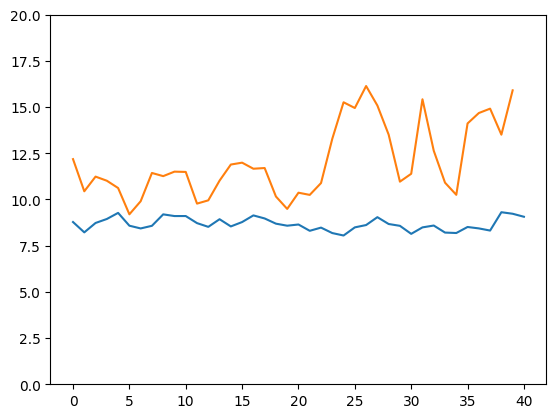

In [86]:
fig4 = plt.figure()
plt.plot(1/ft2s)
plt.plot(1/bt2s)
plt.ylim([0,20])
plt.show()

In [84]:
np.save('bt2s.npy', bt2s)